In [1]:
from PIL import Image
from matplotlib import pyplot as plt
from os_paths import path_to_data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pdb
from skimage import color
from lab_utils import *
import time
from models import ABVAE

In [2]:
# this fella is like color-VAE, but only operates on the 'ab' channels.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:",device)
latent_dim = 64
beta = 4

Using device: cuda


In [4]:
class FfhqDataset(Dataset):
    def __init__(self, root_dir, transform=None, colorchannels='ab', cacheing=True, cachelim=40000):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = os.listdir(root_dir)[0:40000]
        #a dictionary that prevents us from doing more compute than is necessary
        # preprocessing a batch takes about 5x as long as actually training it
        self.cacheing = cacheing
        self.cachelim = cachelim
        self.already_seen_images = {}
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image_path = self.image_paths[idx]
        
        # doing this is about 1000x faster than loading an image
        if self.cacheing and image_path in self.already_seen_images:
            return self.already_seen_images[image_path]
        
        img_name = os.path.join(self.root_dir, self.image_paths[idx])
        image = Image.open(img_name).convert('RGB')
        image = np.array(image) #go from PIL image to nparray so that rgb2lab will work
        image = color.rgb2lab(image).astype(np.float32)
        if self.transform:
            image = self.transform(image)
            
        # scale so that values are between 0 and 1
        image = scale_lab(image)
        image = image[1:] ### isolate ab layers

        if self.cacheing and len(self.already_seen_images) < self.cachelim:
            self.already_seen_images[image_path] = image
        return image
    
    def preshow_image(self,image):
        """
        input: torch.tensor in scaled CIELAB color space wiothout L channel, dims = (2, H, W)
        output: np array in RGB color space 
        """
        empty_L = torch.zeros_like(image[0:1]) + 0.5
        image = torch.cat((empty_L,image),dim=0)
        image = image.numpy()
        image = descale_lab(image) 
        image = np.moveaxis(image, 0,-1) # Convert from (C, H, W) to (H, W, C) so imshow works
        image = color.lab2rgb(image, channel_axis=-1)
        image = (image * 255).astype(np.uint8)
        return image
    def show_grid(self,nrows, ncols):
        n = nrows * ncols
        images = [self[i] for i in range(n)]
        fig, axes = plt.subplots(nrows, ncols)
        for i, ax in enumerate(axes.flat):
            if i < len(images):
                image = self.preshow_image(images[i])
                ax.imshow(image)
                ax.axis('off')
        plt.show()
        
    def preprocess_everything(self):
        """
        preprocess everything up front
        images load about 1000x faster when preprocessed
        """
        t0 = time.time()
        n = len(self)
        print(f"Preprocessing {n} images")
        update_block = n // 100
        percent_complete = 0
        for i in range(n):
            if i % update_block == 0:
                percent_complete += 1
                print(f"{percent_complete}% complete")
            self[i]
        print(time.time() - t0,'seconds')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128),antialias=True),
    #transforms.Normalize((0.5,), (0.5,))
])

path_to_trn = os.path.join(path_to_data,'training')
path_to_tst = os.path.join(path_to_data,'test')
dataset = FfhqDataset(root_dir=path_to_trn, transform=transform, cacheing=True, cachelim=40000)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

tst_dataset = FfhqDataset(root_dir=path_to_tst, transform=transform)
tst_dataloader = DataLoader(tst_dataset, batch_size=32, shuffle=True)

In [5]:
#dataset.preprocess_everything()

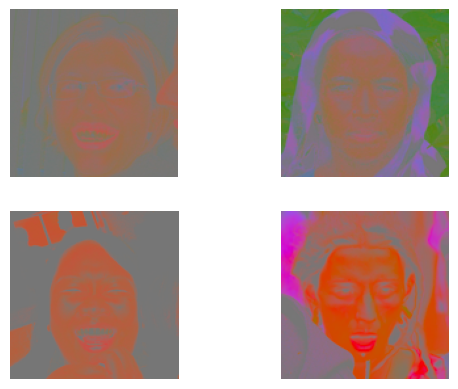

In [6]:
dataset.show_grid(2,2)

In [7]:
def display_tensor_as_image(image):
        image = dataset.preshow_image(image)
        pil_image = Image.fromarray(image)
        display(pil_image)
        return pil_image

In [8]:
def vae_loss(recon_x, x, mu, logvar, criterion,beta=beta):
    BCE = criterion(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

In [9]:
def show_example(model,idx=0,dataset=dataset):
    model.eval()
    example_batch = torch.Tensor.expand(dataset[idx],1,2,128,128).to(device)
    with torch.no_grad():
        example_output = model.forward(example_batch)
    ret = {
        'original':display_tensor_as_image(dataset[idx]),
        'recon':display_tensor_as_image(example_output[0][0].to('cpu'))
    }
    return ret

In [10]:
def generate_samples_from_vae(model,device=device,latent_dim=latent_dim,num_samples=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = model.decoder(z).cpu()
    sample_images = [display_tensor_as_image(sample) for sample in samples]
    return sample_images

In [11]:
cvae = ABVAE(latent_dim).to(device)

In [12]:
def eval_tst_vae_loss(model,criterion,dataloader=tst_dataloader):
    tst_loss = 0
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            batch_loss = vae_loss(recon_batch, data, mu, logvar, criterion)   
            tst_loss += batch_loss
    return tst_loss / len(tst_dataloader.dataset)

In [13]:
learning_rate=1e-3
num_epochs=300
num_epochs_completed = 0

optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
criterion = nn.BCELoss(reduction='sum')

In [14]:
# time to train our VAE!

cvae.train()
for epoch in range(num_epochs):
    train_loss = 0
    for data in dataloader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae(data)
        loss = vae_loss(recon_batch, data, mu, logvar, criterion)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    test_loss = eval_tst_vae_loss(cvae,criterion)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(dataloader.dataset):.4f}, Test loss: {test_loss:.4f}")
    print("Trn Recon example:")
    show_example(cvae)
    print("Tst Recon example:")
    show_example(cvae, dataset=tst_dataset)
    print("Generated example:")
    generate_samples_from_vae(cvae,num_samples=1)
    cvae.train() # because the sample/example functions go into cvae.eval()
    num_epochs_completed += 1

KeyboardInterrupt: 

In [ ]:
eval_tst_vae_loss(cvae,criterion)

In [ ]:
# save the model
test_loss = eval_tst_vae_loss(cvae,criterion)
savedir = f"latent_dim_{latent_dim}_tst_loss_{test_loss:.4f}_epochs_{num_epochs_completed}_beta_{beta}"
path_to_savedirs = os.path.join('.','saved_models','abVAE')
savedirpath = os.path.join(path_to_savedirs,savedir)
if savedir not in os.listdir(path_to_savedirs):
    os.mkdir(savedirpath)
savepath = os.path.join(savedirpath,"state_dict.pth")
torch.save(cvae.state_dict(), savepath)

# save some example images
num_examples_to_save = 8
print("Trn Recon example(s):")
trn_recon_examples = [show_example(cvae,idx = n,dataset=dataset) for n in range(num_examples_to_save)]
print("Tst Recon example(s):")
tst_recon_examples = [show_example(cvae,idx = n, dataset=tst_dataset) for n in range(num_examples_to_save)]
print("Generated example(s):")
generated_examples = generate_samples_from_vae(cvae,num_samples=num_examples_to_save)

reconpath = os.path.join(savedirpath,'recon')
if not 'recon' in os.listdir(savedirpath):
    os.mkdir(reconpath)
if not 'tst' in os.listdir(reconpath):
    os.mkdir(os.path.join(reconpath,'tst'))
    
if not 'trn' in os.listdir(reconpath):
    os.mkdir(os.path.join(reconpath,'trn'))
    
if not 'generated' in os.listdir(savedirpath):
    os.mkdir(os.path.join(savedirpath,'generated'))
for i in range(num_examples_to_save):
    trn_recon_examples[i]['original'].save(os.path.join(reconpath, 'trn', f"example_{i}_original.png"))
    trn_recon_examples[i]['recon'].save(os.path.join(reconpath, 'trn', f"example_{i}_recon.png"))
    tst_recon_examples[i]['original'].save(os.path.join(reconpath, 'tst', f"example_{i}_original.png"))
    tst_recon_examples[i]['recon'].save(os.path.join(reconpath, 'tst', f"example_{i}_recon.png"))
    generated_examples[i].save(os.path.join(savedirpath, 'generated', f"example_{i}.png"))

In [ ]:
generate_samples_from_vae(cvae,num_samples=10)